# Part 3: State of the Art Comparison
###  Benchmark your model against the SOA with the full dataset now available.

In [3]:
!pip install evaluate scikit-multilearn optuna wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.7 MB/s eta 0:00:00


In [1]:
!pip install --upgrade fsspec datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Imports and basic Setup

In [5]:
# load necessary libraries
import os
import time
import torch
import optuna
import random
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from optuna.trial import TrialState

from typing import Optional, Union, Any, Dict

from datasets import Dataset
from datasets import load_dataset, DatasetDict

from transformers import (AutoTokenizer, TFAutoModel, pipeline, MarianMTModel, MarianTokenizer,
                         AutoModelForSequenceClassification, TrainingArguments, Trainer,
                         AutoModelForMaskedLM, EarlyStoppingCallback)

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split

import google.generativeai as genai
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the dataset from Hugging Face
from datasets import load_dataset
df = load_dataset("Arsive/toxicity_classification_jigsaw")

README.md:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

train_dataset.csv:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

val_dataset.csv:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

test_dataset.csv:   0%|          | 0.00/62.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25960 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6490 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153164 [00:00<?, ? examples/s]

In [6]:
# set global seeds to all the processes
def set_global_seeds(seed=42):
    # Python
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # TensorFlow
    tf.random.set_seed(seed)
    # to have compatibiliy with GPU
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

set_global_seeds(42)
seed=42

model_ckpt   = "distilbert/distilbert-base-uncased"
num_labels   = 5
max_length   = 128                   # truncate / pad length
batch_size   = 16

In [7]:
# Define Tokenizer
tok = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize(batch):
    tokenized = tok(
        batch["comment_text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    tokenized["labels"] = [
        [float(batch[label][i]) for label in labels]
        for i in range(len(batch["comment_text"]))
    ]
    return tokenized

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
# convert the datasets to pandas DataFrames
test = df["test"].to_pandas()
train = df["train"].to_pandas()
val = df["validation"].to_pandas()

# Full Dataset Training

## Setup

In order to evlauate correctly the training with different percentages of the full dataset, we use a stratified sampling in which we keep the same proportion of labels --- the one in the full dataset---  for each percentage. This allows us apply the a weighted-cross-entropy loss function across all runs, keeping experiments consistent. Recall that the proportion of labels is the following:

severe_toxic: 1298 samples (5.00%)
obscene: 6804 samples (26.21%)
threat: 373 samples (1.44%)
insult: 6345 samples (24.44%)
identity_hate: 1124 samples (4.33%)


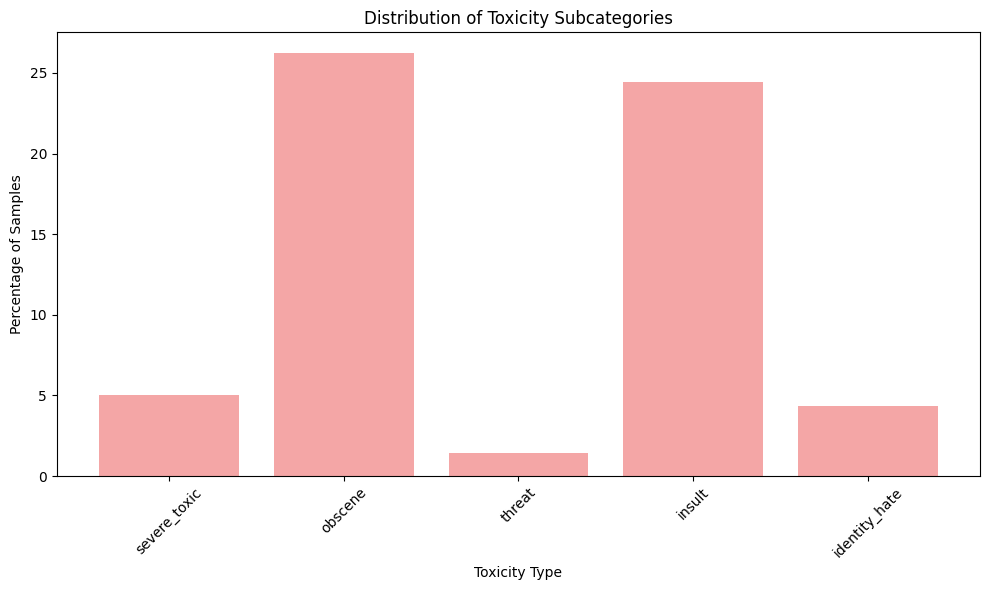

In [ ]:
toxicity_columns = [col for col in train.columns if col in ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
if toxicity_columns:
    for col in toxicity_columns:
        positive_count = train[col].sum()
        percentage = (positive_count / len(train)) * 100
        print(f"{col}: {positive_count} samples ({percentage:.2f}%)")

    # distribution of subcategories
    plt.figure(figsize=(10, 6))
    toxicity_stats = {}
    for col in toxicity_columns:
        toxicity_stats[col] = (train[col].sum() / len(train)) * 100

    plt.bar(toxicity_stats.keys(), toxicity_stats.values(), color='lightcoral', alpha=0.7)
    plt.title('Distribution of Toxicity Subcategories')
    plt.xlabel('Toxicity Type')
    plt.ylabel('Percentage of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Note that we exclude the **Threat** Category because of its extreme class imbalance.

In [9]:
# drop the 'threat' column as we won't use it - too unbalanced class
train = train.drop(columns=["threat"])
test = test.drop(columns=["threat"])
val = val.drop(columns=["threat"])

Prior to starting all runs, we define a base function to get the subset of data we require given a specified percentage. This function uses the `iterative_train_test_split` from the `scikit-multilearn` package, that we can use to extract a stratified sample of size `percentage` (e.g. 0.01 for 1 %) that preserves each label's marginal frequency.  

In [12]:
labels= ["toxic", "severe_toxic", "obscene", "insult", "identity_hate"]
def get_stratified_subset(
    df: pd.DataFrame,
    percentage: float,
    label_cols= ["toxic", "severe_toxic", "obscene", "insult", "identity_hate"],
    random_state: int = 42
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns a stratified subset of `df` of size `percentage * len(df)` that
    preserves each label’s marginal frequency for the multilabel columns in `label_cols`.

    Args:
      df            : pandas DataFrame containing the full dataset.
      label_cols    : list of column-names (strings) for the multilabel targets.
      percentage    : float in (0,1], fraction of df to sample (e.g. 0.01 for 1%).
      random_state  : int, seed for reproducibility (passed to `numpy.random.seed`).

    Returns:
      (df_subset, df_remainder):
        df_subset    : DataFrame of stratified {percentage * 100}% of rows.
        df_remainder : DataFrame of the remaining rows.
    """
    np.random.seed(random_state)

    # 1. Build feature array X (dummy columns) and target array Y (multilabel)
    X_dummy = np.zeros((len(df), 1))  # dummy features, not used for sampling
    Y = df[label_cols].values.astype(int)  # shape: (n_rows, n_labels)

    # 2. Call iterative_train_test_split with test_size = percentage
    X_rem, Y_rem, X_sub, Y_sub = iterative_train_test_split(
        X_dummy, Y, test_size=percentage
    )

    # The indices of X_sub in X_dummy correspond to the rows chosen,
    # but iterative_train_test_split returns only arrays, not indices. To recover indices,
    # we'll identify which rows in Y match Y_sub (in order) along with a running mask.

    # 3. Recover the row indices for the subset
    #    We know X_dummy is all zeros, so we match based on the order:
    #    The function guarantees that X_sub (and Y_sub) correspond to a subset of the original rows in order.
    #    We can do a simple approach: compare rows of Y_sub to rows of Y in order,
    #    marking off matches until we have collected all subset indices.

    full_indices = np.arange(len(df))
    used = np.zeros(len(df), dtype=bool)
    subset_indices = []

    for row in Y_sub:
        # find the first un-used row in Y that matches `row`
        matches = np.where((Y == row).all(axis=1))[0]
        for m in matches:
            if not used[m]:
                subset_indices.append(m)
                used[m] = True
                break

    subset_indices = np.array(subset_indices, dtype=int)
    remainder_indices = np.setdiff1d(full_indices, subset_indices)

    # 4. Build DataFrames
    df_subset = df.iloc[subset_indices].reset_index(drop=True)
    df_remainder = df.iloc[remainder_indices].reset_index(drop=True)
    return df_subset, df_remainder

### Define Metrics

To evaluate our model's performance, we define a compute_metrics() function.

This function returns:

- **Accuracy**: How many predictions were correct?
- **Precision**: Of the predicted positives, how many were correct?
- **Recall**: Of the actual positives, how many did we catch?
- **f1 score**: A mixture of Precision and Recall.

In [10]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")
metric_f1        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Cast labels to integer type before passing to metrics
    labels_int = labels.astype(int)

    # Flatten the predictions and references for evaluation metrics
    preds_flat = preds.flatten()
    labels_int_flat = labels_int.flatten()

    # Use the flattened arrays for computing metrics
    # Note: Accuracy on flattened arrays represents overall element-wise accuracy.
    # For multi-label accuracy, you might want to compute sample-based metrics,
    # but for average="macro" precision/recall/f1, flattening is appropriate.
    acc  = metric_accuracy.compute(predictions=preds_flat, references=labels_int_flat)
    prec = metric_precision.compute(predictions=preds_flat, references=labels_int_flat, average="macro")
    rec  = metric_recall.compute(predictions=preds_flat, references=labels_int_flat, average="macro")
    f1   = metric_f1.compute(predictions=preds_flat, references=labels_int_flat, average="macro")

    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
        "f1":        f1["f1"],
    }

### Define Loss Function

Given the multi label classification nature of our problem, we use the **BCEWithLogitsLoss** loss function. This loss function differs from the more common **Cross Entropy Loss** because it treats each label prediction as an independent binary classification task, applying a separate sigmoid function to each output and computing binary cross-entropy loss per label. In contrast, Cross Entropy Loss assumes that each input belongs to exactly one class out of many and applies a softmax over all output logits, which is appropriate for single-label, multi-class problems. Therefore, **BCEWithLogitsLoss** is more suited for a multilabel classification  problem like this one, where each comment can be simultaneously classified under multiple toxicity sublabels (e.g., both toxic and obscene at once).

In [14]:
# Compute the frequency of each label in the training set
label_sums = train[labels].sum()
label_counts = torch.tensor(label_sums.values, dtype=torch.float32)

# Compute the number of negative samples per class
total_samples = len(train)
neg_counts = total_samples - label_counts

# Compute pos_weight = neg / pos
pos_weight = neg_counts / label_counts
print("pos_weight:", pos_weight)


pos_weight: tensor([ 1.1221, 19.0000,  2.8154,  3.0914, 22.0961])


In [16]:
class WeightedLossTrainer(Trainer):
    def __init__(self, pos_weight, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss    = self.loss_fn(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

pos_weight_tensor = pos_weight.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

### Multi Label classification evaluation

Below we define an evaluation function that computes our metrics per class, as well as a confusion matrix. This allows us to do more in-depth evaluations and error analysis of our fine tuned models. The function applies **Sigmoid** separately to the outputted logits, and uses a probability threshold of 0.5 (that can be modified) to get binary predictions.

In [11]:
def evaluate_multilabel_model(
    trainer,
    eval_dataset,
    label_names,
    threshold=0.5,
    plot_confusion=True,
    normalize_confusion=True
):
    """
    Performs detailed evaluation of a multi-label classification model trained with Hugging Face Trainer.

    Args:
        trainer (Trainer): Trained Hugging Face Trainer object.
        eval_dataset (Dataset): Tokenized evaluation dataset.
        label_names (List[str]): List of label column names (e.g., ["toxic", ...]).
        threshold (float): Threshold for converting sigmoid outputs to binary (default: 0.5).
        plot_confusion (bool): Whether to plot confusion matrices.
        normalize_confusion (bool): If True, display percentages instead of absolute counts.

    Prints:
        - Classification report with per-class precision/recall/F1
        - Confusion matrices (optionally normalized and visualized)
    """
    # 1. Predict and threshold
    predictions_output = trainer.predict(eval_dataset)
    logits = predictions_output.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_pred = (probs >= threshold).astype(int)
    y_true = predictions_output.label_ids

    # 2. Classification report
    print("\n Classification Report:")
    report = classification_report(
        y_true,
        y_pred,
        target_names=label_names,
        digits=4
    )
    print(report)

    # 3. Confusion Matrices
    print("\n Confusion Matrices:")
    conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

    for i, label in enumerate(label_names):
        cm = conf_matrices[i]

        # Normalize to percentage if requested
        if normalize_confusion:
            cm_sum = cm.sum()
            cm = cm.astype("float") / cm_sum * 100 if cm_sum > 0 else cm

        print(f"\nConfusion Matrix for '{label}':")
        print(np.round(cm, 2))

        if plot_confusion:
            plt.figure(figsize=(3, 3))
            sns.heatmap(
                cm,
                annot=True,
                fmt=".1f" if normalize_confusion else "d",
                cmap="Blues",
                cbar=False
            )
            plt.title(f"Confusion Matrix: {label}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.show()

### Pipeline Definition

The pipeline for this section is the following:

For each percentage of training data value (1%, 10%, 25%, 50%, 75%, 100%) we:
0. Reload the baseline model (DistilBERT) with its pretrained weights.
1. Sample the data in such a way that we maintain an equal proportion of labels.
2. Train a fresh baseline model (using the same set of parameters) using the extracted data.
3. Evaluate the model and perform Error Analysis
4. Apply part 2 techniques and compare to the base results (with raw data)

Once we have run all models, we compute the learning curves and plottings.

We can already tokenize the validation set, as it will not change across the different runs

In [13]:
val = Dataset.from_pandas(val).remove_columns("id")
val = val.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
val.set_format("torch", ["input_ids","attention_mask","labels"])

Map:   0%|          | 0/6490 [00:00<?, ? examples/s]

## Training with 1% of the dataset

In [ ]:
# Create the dataset
df_1pct, df_99pct = get_stratified_subset(train, percentage=0.01)
print("1% subset size:", len(df_1pct))

# Verify approximate label frequencies in df_1pct
freqs_1pct = df_1pct[labels].sum() / len(df_1pct) * 100
print("\nLabel frequencies in the 1% subset (in %):")
print(freqs_1pct.round(2))


1% subset size: 260

Label frequencies in the 1% subset (in %):
toxic            46.92
severe_toxic      5.00
obscene          26.15
insult           24.23
identity_hate     4.23
dtype: float64


In [ ]:
# Apply map() on out train dataset:
train_1_base_ds = Dataset.from_pandas(df_1pct).remove_columns("id")
train_1_base_ds = train_1_base_ds.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_1_base_ds.set_format("torch", ["input_ids","attention_mask","labels"])

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Now we can load the model and its respective arguments

In [ ]:
# Load the Model
model     = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


By specifying that the problem type is `multi_label_classification`, the `AutoModelForSequenceClassification` package uses the **BCEWithLogitsLoss** loss function.

We first test out the 1% dataset fine tuning model performance using an **unweighted loss function** , and then test the weighted loss function, which is expected to work  better, as it compensates for the strong class imbalance by assigning higher importance to rare labels during training.

In [17]:
args_1_base = TrainingArguments(
    output_dir          = "./bert_1",
    eval_strategy       = "epoch",
    save_strategy       = "no",
    logging_strategy    = "steps",
    logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 10,
    weight_decay        = 0.01,
    load_best_model_at_end = False,
    metric_for_best_model = "eval_f1",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True # Enable mixed precision training
)

In [ ]:
trainer_1_base = Trainer(
    model           = model,
    args            = args_1_base,
    train_dataset   = train_1_base_ds,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

### Base Results (Untrained Model)

In [ ]:
base_results = trainer_1_base.evaluate(eval_dataset=val)
print("\nEvaluation Results (1% dataset):")
print(f"  Accuracy:  {base_results['eval_accuracy']:.4f}")
print(f"  Precision: {base_results['eval_precision']:.4f}")
print(f"  Recall:    {base_results['eval_recall']:.4f}")
print(f"  F1 Score:  {base_results['eval_f1']:.4f}")



Evaluation Results (1% dataset):
  Accuracy:  0.3733
  Precision: 0.4055
  Recall:    0.3598
  F1 Score:  0.3377


In [ ]:
# TRAIN THE MODEL!
train_output_1_base = trainer_1_base.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.483270,0.777966,0.662429,0.655610,0.658805
2,No log,0.402120,0.848875,0.820051,0.680316,0.715236
3,0.471500,0.343434,0.897781,0.875914,0.799859,0.829682
4,0.471500,0.307219,0.903482,0.858525,0.846547,0.852318
5,0.471500,0.280553,0.905331,0.863900,0.844657,0.853728
6,0.276600,0.266643,0.905239,0.869216,0.835574,0.850750
7,0.276600,0.269426,0.900216,0.846073,0.860485,0.852945
8,0.276600,0.259761,0.904191,0.856350,0.854623,0.855482
9,0.219100,0.253904,0.905639,0.867875,0.839265,0.852374
10,0.219100,0.253653,0.905208,0.863555,0.844740,0.853621


In [ ]:
eval_results_1_base = trainer_1_base.evaluate(eval_dataset=val)

print("\nEvaluation Results (1% dataset):")
print(f"  Accuracy:  {eval_results_1_base['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_1_base['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_1_base['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_1_base['eval_f1']:.4f}")



Evaluation Results (1% dataset):
  Accuracy:  0.9052
  Precision: 0.8636
  Recall:    0.8447
  F1 Score:  0.8536


Time for a deeper error analysis. Let's run the multilabel evaluator.


 Classification Report:
               precision    recall  f1-score   support

        toxic     0.8812    0.8728    0.8770      3034
 severe_toxic     0.0000    0.0000    0.0000       320
      obscene     0.7621    0.7907    0.7761      1653
       insult     0.6716    0.7056    0.6881      1559
identity_hate     0.0000    0.0000    0.0000       262

    micro avg     0.7951    0.7403    0.7667      6828
    macro avg     0.4630    0.4738    0.4682      6828
 weighted avg     0.7294    0.7403    0.7347      6828
  samples avg     0.3638    0.3589    0.3438      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[47.75  5.5 ]
 [ 5.95 40.8 ]]


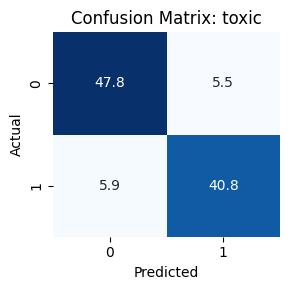


Confusion Matrix for 'severe_toxic':
[[95.07  0.  ]
 [ 4.93  0.  ]]


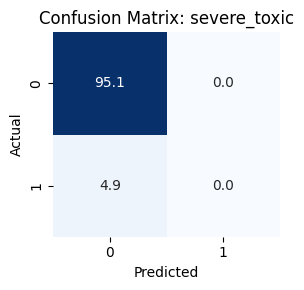


Confusion Matrix for 'obscene':
[[68.24  6.29]
 [ 5.33 20.14]]


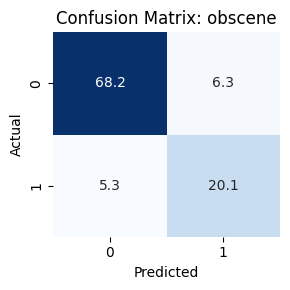


Confusion Matrix for 'insult':
[[67.69  8.29]
 [ 7.07 16.95]]


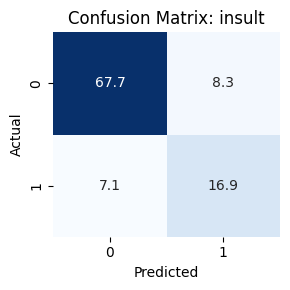


Confusion Matrix for 'identity_hate':
[[95.96  0.  ]
 [ 4.04  0.  ]]


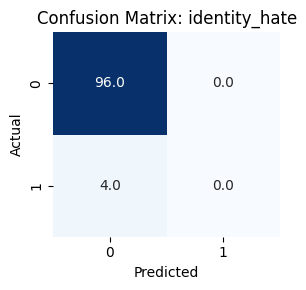

In [ ]:
evaluate_multilabel_model(
    trainer=trainer_1_base,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
)

### Weighted loss function

In [40]:
# Load the Model
model     = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

trainer_1_w = Trainer(
    model           = model,
    args            = args_1_base,
    train_dataset   = train_1_base_ds,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# TRAIN THE MODEL!
trainer_1_w.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.496845,0.776826,0.660981,0.654887,0.657761
2,No log,0.399041,0.860493,0.838730,0.706204,0.743470
3,0.481100,0.338147,0.903112,0.871695,0.823861,0.844486
4,0.481100,0.304766,0.902958,0.854509,0.852715,0.853607
5,0.481100,0.283330,0.903267,0.853921,0.855703,0.854807
6,0.275300,0.266733,0.906317,0.869950,0.838782,0.852957
7,0.275300,0.262845,0.904992,0.859356,0.851908,0.855548
8,0.275300,0.258123,0.905609,0.860149,0.853158,0.856580
9,0.218500,0.252934,0.907119,0.870254,0.841545,0.854705
10,0.218500,0.253081,0.906780,0.865312,0.848421,0.856445


TrainOutput(global_step=170, training_loss=0.3113480680129107, metrics={'train_runtime': 95.5771, 'train_samples_per_second': 27.203, 'train_steps_per_second': 1.779, 'total_flos': 86108415744000.0, 'train_loss': 0.3113480680129107, 'epoch': 10.0})

In [43]:
eval_results_1_w = trainer_1_w.evaluate(eval_dataset=val)

print("\nEvaluation Results (1% dataset):")
print(f"  Accuracy:  {eval_results_1_w['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_1_w['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_1_w['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_1_w['eval_f1']:.4f}")


Evaluation Results (1% dataset):
  Accuracy:  0.9068
  Precision: 0.8653
  Recall:    0.8484
  F1 Score:  0.8564



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.8830    0.8705    0.8767      3034
 severe_toxic     0.0000    0.0000    0.0000       320
      obscene     0.7555    0.8167    0.7849      1653
       insult     0.6839    0.7146    0.6989      1559
identity_hate     0.0000    0.0000    0.0000       262

    micro avg     0.7968    0.7477    0.7714      6828
    macro avg     0.4645    0.4803    0.4721      6828
 weighted avg     0.7314    0.7477    0.7391      6828
  samples avg     0.3623    0.3615    0.3450      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[47.86  5.39]
 [ 6.06 40.69]]


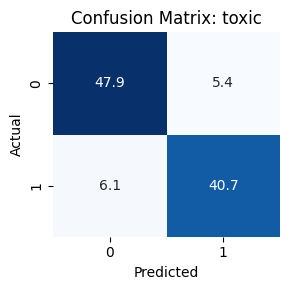


Confusion Matrix for 'severe_toxic':
[[95.07  0.  ]
 [ 4.93  0.  ]]


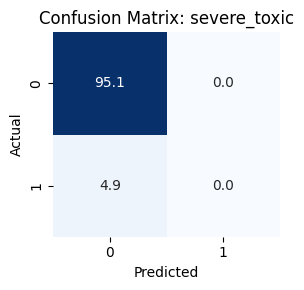


Confusion Matrix for 'obscene':
[[67.8   6.73]
 [ 4.67 20.8 ]]


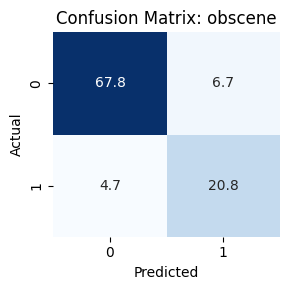


Confusion Matrix for 'insult':
[[68.04  7.94]
 [ 6.86 17.16]]


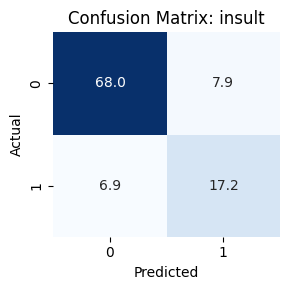


Confusion Matrix for 'identity_hate':
[[95.96  0.  ]
 [ 4.04  0.  ]]


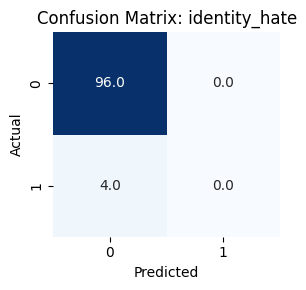

In [44]:
evaluate_multilabel_model(
    trainer=trainer_1_w,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
)

## Part 3 Techniques incorporation

In [18]:
%cd /content/drive/MyDrive/NLP

/content/drive/.shortcut-targets-by-id/1iYj2bCrKcw6XwG4-eDySmWjqPzsgojJ9/NLP


In [ ]:
from DataAugmentor import DataAugmentor
augmentor = DataAugmentor(
    label_cols=["toxic","severe_toxic","obscene","insult","identity_hate"]
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


### Back-translation Augmentation

In [ ]:
# 4) Back‐translation augmentation on 1%
augmented_bt = augmentor.backtranslate(df_1pct)
print("After back-translation, combined size:", len(augmented_bt))

Back-translating: 100%|██████████| 260/260 [32:52<00:00,  7.59s/it]

Original examples: 260
Back-translated examples: 257
After back-translation, combined size: 517


In [ ]:
augmented_bt.to_csv("augmented_bt.csv", index=False)

In [ ]:
# Apply map() on out train dataset:
train_1_bt = Dataset.from_pandas(augmented_bt).remove_columns("id")
train_1_bt = train_1_bt.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_1_bt.set_format("torch", ["input_ids","attention_mask","labels"])

# Load a FRESH DistilBERT model
model_1_translate     = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_1_trans = Trainer(
    model           = model_1_translate,
    args            = args_1_base,
    train_dataset   = train_1_bt,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# TRAIN THE MODEL!
train_output_1_trans = trainer_1_trans.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.406837,0.849738,0.849889,0.665393,0.702365
2,0.481000,0.290609,0.905331,0.885435,0.815866,0.844007
3,0.481000,0.261576,0.907673,0.865968,0.851135,0.858227
4,0.279700,0.249354,0.903698,0.853666,0.858608,0.856099
5,0.207800,0.239663,0.905208,0.868651,0.836307,0.850955
6,0.207800,0.235094,0.906441,0.869977,0.839236,0.853236


In [ ]:
eval_results_1_trans = trainer_1_trans.evaluate(eval_dataset=val)

print("\nEvaluation Results (1% dataset):")
print(f"  Accuracy:  {eval_results_1_trans['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_1_trans['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_1_trans['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_1_trans['eval_f1']:.4f}")


Evaluation Results (1% dataset):
  Accuracy:  0.9064
  Precision: 0.8700
  Recall:    0.8392
  F1 Score:  0.8532



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.8839    0.8804    0.8821      3034
 severe_toxic     0.0000    0.0000    0.0000       320
      obscene     0.7790    0.7441    0.7611      1653
       insult     0.6993    0.6652    0.6818      1559
identity_hate     0.0000    0.0000    0.0000       262

    micro avg     0.8116    0.7232    0.7649      6828
    macro avg     0.4724    0.4579    0.4650      6828
 weighted avg     0.7410    0.7232    0.7319      6828
  samples avg     0.3735    0.3523    0.3450      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[47.84  5.41]
 [ 5.59 41.16]]


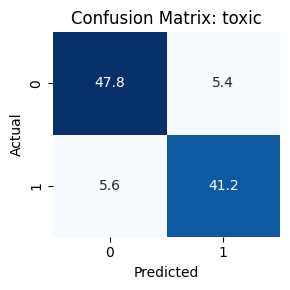


Confusion Matrix for 'severe_toxic':
[[95.07  0.  ]
 [ 4.93  0.  ]]


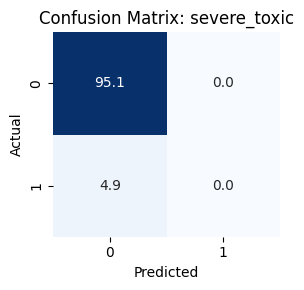


Confusion Matrix for 'obscene':
[[69.15  5.38]
 [ 6.52 18.95]]


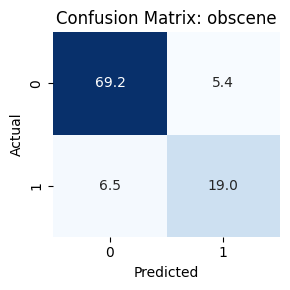


Confusion Matrix for 'insult':
[[69.11  6.87]
 [ 8.04 15.98]]


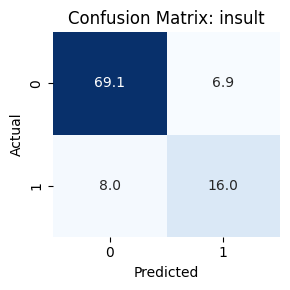


Confusion Matrix for 'identity_hate':
[[95.96  0.  ]
 [ 4.04  0.  ]]


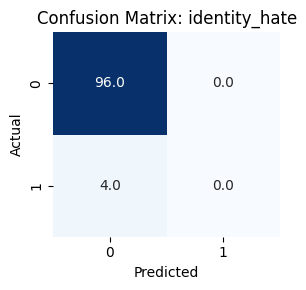

In [ ]:
evaluate_multilabel_model(
    trainer=trainer_1_trans,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5
)

### Zero-Shot Augmentation

To perform the Zero Shot augmentation, we use the same structure than part 2. FOr tha dataset augmentation of the 1% section, we need to carefully select the appropiate number of additional examples to generate. Given that zero-shot labels may contain errors, it is not necessarilly bettet to add as many examples as possible, as this could confuse our model. Therefore, we use 1000 addirional pseudo-labeled examples; roughly 4x times more than our original. Again, to select those we must use a balanced dataset, so we extract then using the previoulsy created function

In [ ]:
df_1000, _ = get_stratified_subset(df_99pct, percentage=0.04) # we input the df_99_pct to avoid labelling examples already in our 1% dataset.

In [ ]:
# 5) Zero-shot augmentation on 1%
augmented_zs = augmentor.zero_shot_pipeline(df_1pct, df_1000, confidence_threshold=0.6)
print("After zero-shot, combined size:", len(augmented_zs))

Running zero-shot classification on 1028 examples (batch_size=16)


Zero-shot classification: 100%|██████████| 65/65 [03:57<00:00,  3.66s/it]


Zero-shot pipeline kept 115 examples (threshold=0.6)
After zero-shot, combined size: 375


In [ ]:
augmented_zs.to_csv("augmented_zs.csv", index=False)

In [ ]:
# Apply map() on out train dataset:
train_1_zs = Dataset.from_pandas(augmented_zs).remove_columns("id")
train_1_zs = train_1_zs.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_1_zs.set_format("torch", ["input_ids","attention_mask","labels"])

# Load a FRESH DistilBERT model
model_1_zs = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

Map:   0%|          | 0/375 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_1_zs = Trainer(
    model           = model_1_zs,
    args            = args_1_base,
    train_dataset   = train_1_zs,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# TRAIN THE MODEL!
train_output_1_zs = trainer_1_zs.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.473887,0.792881,0.841489,0.508641,0.459511
2,No log,0.426719,0.793128,0.670224,0.587326,0.599301
3,0.495500,0.373206,0.835008,0.779224,0.663585,0.692855
4,0.495500,0.357476,0.834299,0.810781,0.636172,0.665341
5,0.370400,0.328447,0.862219,0.808428,0.747045,0.770814
6,0.370400,0.319345,0.863883,0.822281,0.734241,0.764780
7,0.319600,0.323412,0.864253,0.808498,0.756927,0.777828
8,0.319600,0.316447,0.864314,0.815857,0.744666,0.771233
9,0.281200,0.316083,0.861479,0.825125,0.721707,0.754958
10,0.281200,0.310673,0.867797,0.824817,0.746925,0.775448


In [ ]:
eval_results_1_zs = trainer_1_zs.evaluate(eval_dataset=val)

print("\nEvaluation Results (1% dataset):")
print(f"  Accuracy:  {eval_results_1_zs['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_1_zs['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_1_zs['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_1_zs['eval_f1']:.4f}")


Evaluation Results (1% dataset):
  Accuracy:  0.8678
  Precision: 0.8248
  Recall:    0.7469
  F1 Score:  0.7754



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.9258    0.5511    0.6909      3034
 severe_toxic     0.0000    0.0000    0.0000       320
      obscene     0.8848    0.4180    0.5678      1653
       insult     0.5897    0.8416    0.6934      1559
identity_hate     0.0000    0.0000    0.0000       262

    micro avg     0.7637    0.5382    0.6314      6828
    macro avg     0.4800    0.3621    0.3904      6828
 weighted avg     0.7602    0.5382    0.6028      6828
  samples avg     0.2576    0.2343    0.2304      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[51.19  2.06]
 [20.99 25.76]]


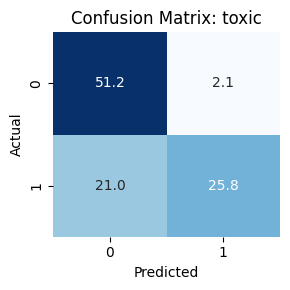


Confusion Matrix for 'severe_toxic':
[[95.07  0.  ]
 [ 4.93  0.  ]]


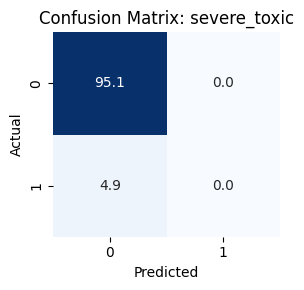


Confusion Matrix for 'obscene':
[[73.14  1.39]
 [14.82 10.65]]


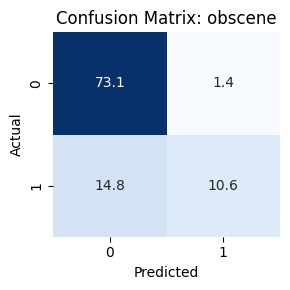


Confusion Matrix for 'insult':
[[61.91 14.07]
 [ 3.81 20.22]]


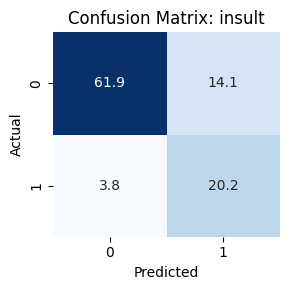


Confusion Matrix for 'identity_hate':
[[95.96  0.  ]
 [ 4.04  0.  ]]


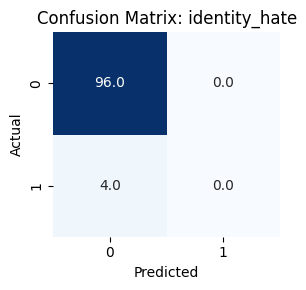

In [ ]:
evaluate_multilabel_model(
    trainer=trainer_1_zs,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5
)

## Training with 10% of the dataset

In [ ]:
# Create the dataset
df_10pct, df_90pct = get_stratified_subset(train, percentage=0.1)
print("1% subset size:", len(df_10pct))

# Verify approximate label frequencies in df_1pct
freqs_10pct = df_10pct[labels].sum() / len(df_10pct) * 100
print("\nLabel frequencies in the 1% subset (in %):")
print(freqs_10pct.round(2))

1% subset size: 2596

Label frequencies in the 1% subset (in %):
toxic            47.11
severe_toxic      5.01
obscene          26.19
insult           24.42
identity_hate     4.31
dtype: float64


In [ ]:
# Apply map() on out train dataset:
train_10_base = Dataset.from_pandas(df_10pct).remove_columns("id")
train_10_base = train_10_base.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_10_base.set_format("torch", ["input_ids","attention_mask","labels"])


Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

In [ ]:
# Load the Model
model10     = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load the Trainer object
trainer_10_base = Trainer(
    model           = model10,
    args            = args_1_base,
    train_dataset   = train_10_base,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# TRAIN THE MODEL!
train_output_10_base = trainer_10_base.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.250700,0.233476,0.908228,0.856704,0.875281,0.865458
2,0.192500,0.197175,0.921202,0.896200,0.858896,0.875702
3,0.143700,0.198138,0.921818,0.908563,0.847308,0.873156
4,0.138900,0.198413,0.923143,0.881976,0.888970,0.885404
5,0.119900,0.190466,0.926656,0.890893,0.887434,0.889147
6,0.098400,0.195137,0.928413,0.897604,0.883659,0.890373
7,0.074200,0.198649,0.928598,0.899472,0.881627,0.890130
8,0.079000,0.201404,0.927427,0.893729,0.885827,0.889694
9,0.068200,0.203508,0.927550,0.890996,0.890954,0.890975
10,0.070900,0.204165,0.927519,0.892171,0.888786,0.890463


In [ ]:
eval_results_10_base = trainer_10_base.evaluate(eval_dataset=val)

print("\nEvaluation Results (1% dataset):")
print(f"  Accuracy:  {eval_results_10_base['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_10_base['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_10_base['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_10_base['eval_f1']:.4f}")


Evaluation Results (1% dataset):
  Accuracy:  0.9275
  Precision: 0.8922
  Recall:    0.8888
  F1 Score:  0.8905



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.8883    0.9252    0.9064      3034
 severe_toxic     0.5823    0.4531    0.5097       320
      obscene     0.8415    0.8415    0.8415      1653
       insult     0.7575    0.7473    0.7523      1559
identity_hate     0.7027    0.3969    0.5073       262

    micro avg     0.8317    0.8219    0.8268      6828
    macro avg     0.7545    0.6728    0.7034      6828
 weighted avg     0.8256    0.8219    0.8216      6828
  samples avg     0.3968    0.3999    0.3850      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[47.81  5.44]
 [ 3.5  43.25]]


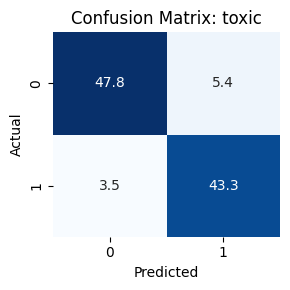


Confusion Matrix for 'severe_toxic':
[[93.47  1.6 ]
 [ 2.7   2.23]]


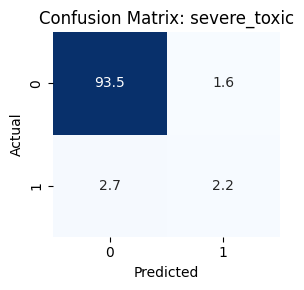


Confusion Matrix for 'obscene':
[[70.49  4.04]
 [ 4.04 21.43]]


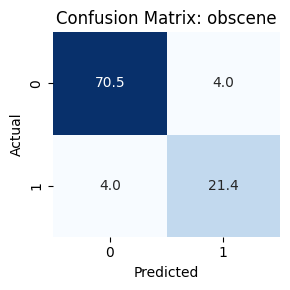


Confusion Matrix for 'insult':
[[70.23  5.75]
 [ 6.07 17.95]]


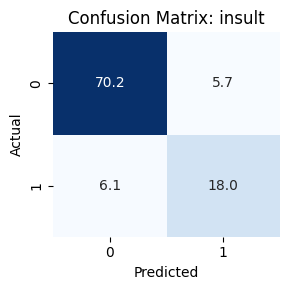


Confusion Matrix for 'identity_hate':
[[95.29  0.68]
 [ 2.43  1.6 ]]


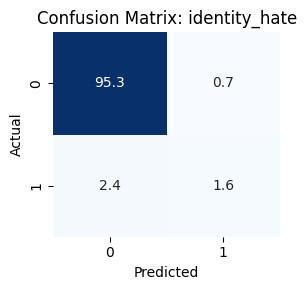

In [ ]:
# Run Error Analysis function
evaluate_multilabel_model(
    trainer=trainer_10_base,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5
)

### Part 2 techniques incorporation

### Back Translation

As previously discussed, we reuse the same augmented dataset generated in the 1% section to avoid the significant computational cost of regenerating them for each run. Since the saved CSV files contain the concatenation of the original 1% dataset with the corresponding augmented examples, we can simply drop the first 260 rows to isolate the augmented portion.

In [57]:
augmented_bt= pd.read_csv("augmented_bt.csv")
augmented_bt= augmented_bt.iloc[260:].reset_index(drop=True)
print("Augmented-only backtranslation set:", augmented_bt.shape)
df_bt= pd.concat(
            [df_10pct.reset_index(drop=True), augmented_bt.reset_index(drop=True)],
            ignore_index=True
        )

Augmented-only backtranslation set: (257, 7)


In [58]:
# Apply map() on out train dataset:
train_10_bt = Dataset.from_pandas(df_bt).remove_columns("id")
train_10_bt = train_10_bt.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_10_bt.set_format("torch", ["input_ids","attention_mask","labels"])

# Load a FRESH DistilBERT model
model_10_bt = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

Map:   0%|          | 0/2853 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
trainer_10_bt = Trainer(
    model           = model_10_bt,
    args            = args_1_base,
    train_dataset   = train_10_bt,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [60]:
# TRAIN THE MODEL!
trainer_10_bt.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.251300,0.217147,0.915378,0.896275,0.838557,0.863004
2,0.198700,0.207868,0.916364,0.867003,0.891229,0.878238
3,0.170400,0.196025,0.923051,0.887715,0.878061,0.882760
4,0.148100,0.191761,0.924314,0.904421,0.860008,0.879667
5,0.118500,0.193968,0.924037,0.887764,0.882016,0.884845
6,0.093600,0.201156,0.925485,0.884454,0.894481,0.889327
7,0.079900,0.200893,0.925886,0.885638,0.893876,0.889662
8,0.064900,0.207172,0.926656,0.892105,0.885393,0.888688
9,0.061700,0.209610,0.925362,0.886276,0.890321,0.888276
10,0.048800,0.209407,0.926194,0.889804,0.887410,0.888599


TrainOutput(global_step=1790, training_loss=0.13045156321712045, metrics={'train_runtime': 188.7006, 'train_samples_per_second': 151.192, 'train_steps_per_second': 9.486, 'total_flos': 944874269683200.0, 'train_loss': 0.13045156321712045, 'epoch': 10.0})

In [61]:
eval_results_10_bt = trainer_10_bt.evaluate(eval_dataset=val)

print("\nEvaluation Results (1% dataset):")
print(f"  Accuracy:  {eval_results_10_bt['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_10_bt['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_10_bt['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_10_bt['eval_f1']:.4f}")


Evaluation Results (1% dataset):
  Accuracy:  0.9262
  Precision: 0.8898
  Recall:    0.8874
  F1 Score:  0.8886



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.8785    0.9318    0.9044      3034
 severe_toxic     0.5663    0.4406    0.4956       320
      obscene     0.8386    0.8361    0.8373      1653
       insult     0.7578    0.7447    0.7512      1559
identity_hate     0.7339    0.3473    0.4715       262

    micro avg     0.8274    0.8204    0.8239      6828
    macro avg     0.7550    0.6601    0.6920      6828
 weighted avg     0.8211    0.8204    0.8174      6828
  samples avg     0.4004    0.4020    0.3877      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[47.23  6.02]
 [ 3.19 43.56]]


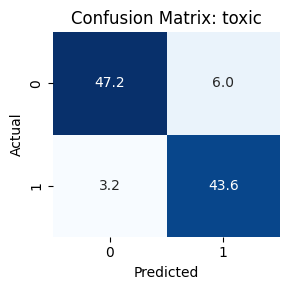


Confusion Matrix for 'severe_toxic':
[[93.41  1.66]
 [ 2.76  2.17]]


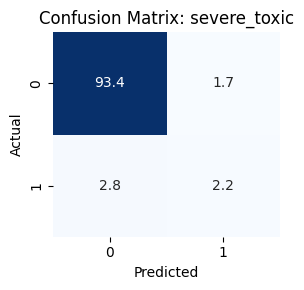


Confusion Matrix for 'obscene':
[[70.43  4.1 ]
 [ 4.18 21.29]]


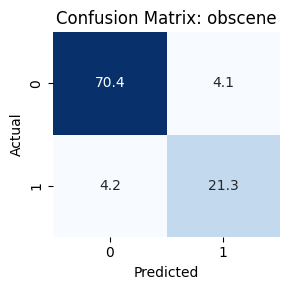


Confusion Matrix for 'insult':
[[70.26  5.72]
 [ 6.13 17.89]]


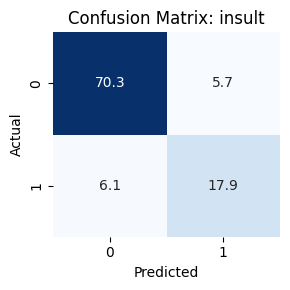


Confusion Matrix for 'identity_hate':
[[95.45  0.51]
 [ 2.63  1.4 ]]


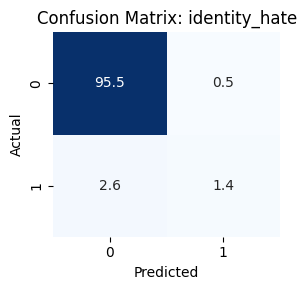

In [62]:
evaluate_multilabel_model(
    trainer=trainer_10_bt,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=True
)

### Zero Shot Learning

Given that generating 10000 examples is very time consuming, we use the same 1000 pseudo-labeleed examples from the 1% section. This also allows us to test whether a different size of the augmentation dataset has a different impact.

In [50]:
augmented_zs= pd.read_csv("augmented_zs.csv")
augmented_zs= augmented_zs.iloc[260:].reset_index(drop=True)
print("Augmented-only backtranslation set:", augmented_zs.shape)

df_zs= pd.concat(
            [df_10pct.reset_index(drop=True), augmented_zs.reset_index(drop=True)],
            ignore_index=True
        )

Augmented-only backtranslation set: (115, 7)


In [51]:
# Apply map() on out train dataset:
train_10_zs = Dataset.from_pandas(df_zs).remove_columns("id")
train_10_zs = train_10_zs.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_10_zs.set_format("torch", ["input_ids","attention_mask","labels"])

# Load a FRESH DistilBERT model
model_10_zs = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

Map:   0%|          | 0/2711 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
trainer_10_zs = Trainer(
    model           = model_10_zs,
    args            = args_1_base,
    train_dataset   = train_10_zs,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [53]:
# TRAIN THE MODEL!
train_output_10_zs = trainer_10_zs.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.271000,0.226049,0.913436,0.879520,0.852582,0.865032
2,0.237000,0.201515,0.917473,0.873134,0.881458,0.877195
3,0.191700,0.191007,0.924314,0.896165,0.870267,0.882325
4,0.168200,0.187711,0.925547,0.889363,0.885496,0.887409
5,0.157800,0.193557,0.924530,0.881690,0.895971,0.888542
6,0.151100,0.189169,0.927211,0.896791,0.880266,0.888166
7,0.126200,0.191950,0.927304,0.895909,0.881936,0.888662
8,0.118600,0.199024,0.926441,0.892018,0.884666,0.888269
9,0.098400,0.197912,0.926841,0.891647,0.886907,0.889247
10,0.093400,0.199245,0.927026,0.893564,0.884499,0.888921


In [55]:
eval_results_10_zs = trainer_10_zs.evaluate(eval_dataset=val)

print("\nEvaluation Results (1% dataset):")
print(f"  Accuracy:  {eval_results_10_zs['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_10_zs['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_10_zs['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_10_zs['eval_f1']:.4f}")


Evaluation Results (1% dataset):
  Accuracy:  0.9270
  Precision: 0.8936
  Recall:    0.8845
  F1 Score:  0.8889



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.8857    0.9268    0.9058      3034
 severe_toxic     0.5867    0.4125    0.4844       320
      obscene     0.8555    0.8240    0.8394      1653
       insult     0.7639    0.7223    0.7425      1559
identity_hate     0.7067    0.4046    0.5146       262

    micro avg     0.8371    0.8111    0.8239      6828
    macro avg     0.7597    0.6580    0.6973      6828
 weighted avg     0.8297    0.8111    0.8177      6828
  samples avg     0.3994    0.3964    0.3845      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[47.66  5.59]
 [ 3.42 43.33]]


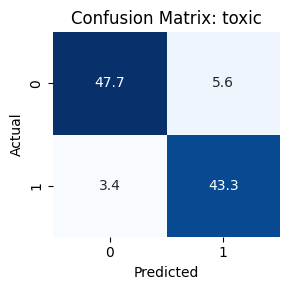


Confusion Matrix for 'severe_toxic':
[[93.64  1.43]
 [ 2.9   2.03]]


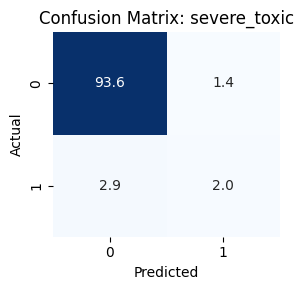


Confusion Matrix for 'obscene':
[[70.99  3.54]
 [ 4.48 20.99]]


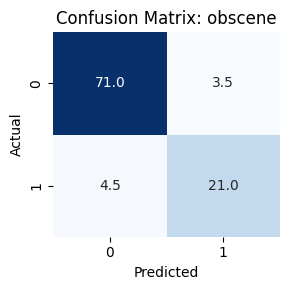


Confusion Matrix for 'insult':
[[70.62  5.36]
 [ 6.67 17.35]]


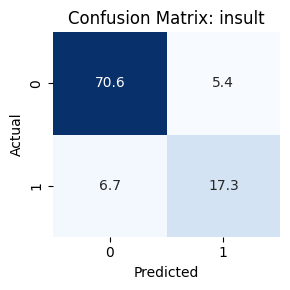


Confusion Matrix for 'identity_hate':
[[95.29  0.68]
 [ 2.4   1.63]]


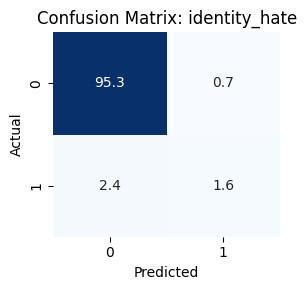

In [56]:
evaluate_multilabel_model(
    trainer=trainer_10_zs,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=True
)

### Weighted Loss Function
We now try to train the model using the Weighted loss function, and evaluate whether the more uncommon classes get better results.

In [ ]:
model10_weighted  = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_10_weighted = WeightedLossTrainer(
    pos_weight=pos_weight_tensor,
    model=model10_weighted,
    args=args_1_base,
    train_dataset=train_10_base,
    eval_dataset=val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer_10_weighted.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.645100,0.566454,0.853066,0.780627,0.845614,0.803400
2,0.433000,0.487930,0.868505,0.801110,0.882463,0.827624
3,0.314400,0.520853,0.910539,0.857854,0.885500,0.870491
4,0.301000,0.488885,0.899661,0.837843,0.903105,0.863038
5,0.234400,0.556914,0.909153,0.850995,0.906752,0.873794
6,0.205500,0.591861,0.915347,0.861120,0.905410,0.880219
7,0.132400,0.626218,0.916980,0.865342,0.900106,0.880891
8,0.127500,0.713973,0.918983,0.869363,0.899065,0.882900
9,0.108300,0.688234,0.917997,0.866223,0.903436,0.882732
10,0.116200,0.711735,0.919661,0.869445,0.902771,0.884450


TrainOutput(global_step=1630, training_loss=0.2855979565462452, metrics={'train_runtime': 199.0858, 'train_samples_per_second': 130.396, 'train_steps_per_second': 8.187, 'total_flos': 859759412582400.0, 'train_loss': 0.2855979565462452, 'epoch': 10.0})

It is also interesting to observe that, despite consistent improvements in F1 score and other evaluation metrics across epochs, the validation loss does not consistently decrease. At first glance this might seem counterintuitive, yet it is not necessarilly something to worry about, as the two values measure slighlty different behaviours.

F1 computes the scores for the binary predictions, after applying the 0.5 threshold; this means that, for each label, if the probability of it being positive is above 0.5, the sigmoid function turns it into a 1, and the F1 score only "sees" that binary 1 or 0 classification.

In contrast, the binary corss-entropy (BCE) loss takes the probability into account. This means that a wrong prediction at probability 0.99 is penalized far more than another one at 0.51. Therefore, what we learn from the loss function increase is that the model steadily becomes more confident as epochs advance, but this does not mean that results become worse. To analyze that, we look at the per class metrics.


 Classification Report:
               precision    recall  f1-score   support

        toxic     0.8712    0.9341    0.9015      3034
 severe_toxic     0.4593    0.6344    0.5328       320
      obscene     0.8002    0.8845    0.8402      1653
       insult     0.6894    0.8358    0.7556      1559
identity_hate     0.5488    0.6221    0.5832       262

    micro avg     0.7738    0.8736    0.8207      6828
    macro avg     0.6738    0.7822    0.7227      6828
 weighted avg     0.7808    0.8736    0.8239      6828
  samples avg     0.3792    0.4228    0.3857      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[46.8   6.46]
 [ 3.08 43.67]]


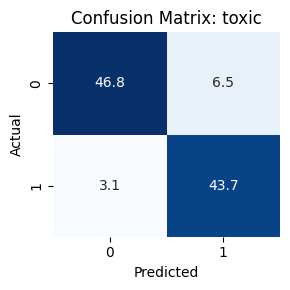


Confusion Matrix for 'severe_toxic':
[[91.39  3.68]
 [ 1.8   3.13]]


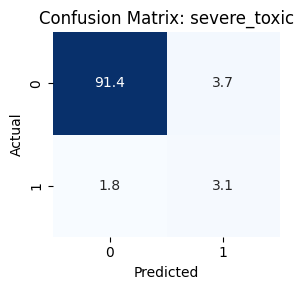


Confusion Matrix for 'obscene':
[[68.91  5.62]
 [ 2.94 22.53]]


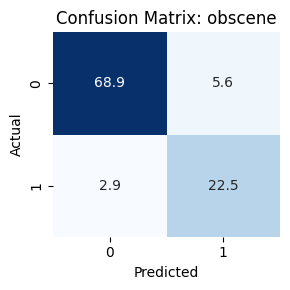


Confusion Matrix for 'insult':
[[66.93  9.04]
 [ 3.94 20.08]]


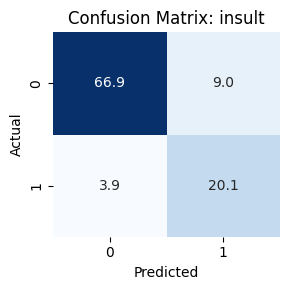


Confusion Matrix for 'identity_hate':
[[93.9   2.06]
 [ 1.53  2.51]]


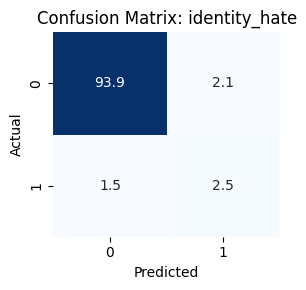

In [ ]:
# Run Error Analysis function
evaluate_multilabel_model(
    trainer=trainer_10_weighted,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5
)

From the results above we can observe how both rare classes (sever_toxic and identity_hate) get improved F1 scores, derived form the loss function giving more importance to the wrongly classified examples. Therefore, we will use the weighted loss for the rest of the section

## 25% Dataset

In [ ]:
# Create the dataset
df_25pct, _ = get_stratified_subset(train, percentage=0.25)
print("25% subset size:", len(df_25pct))

# Verify approximate label frequencies in df_1pct
freqs_25pct = df_25pct[labels].sum() / len(df_25pct) * 100
print("\nLabel frequencies in the 25% subset (in %):")
print(freqs_25pct.round(2))

# Apply map() on out train dataset:
train_25_base = Dataset.from_pandas(df_25pct).remove_columns("id")
train_25_base = train_25_base.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_25_base.set_format("torch", ["input_ids","attention_mask","labels"])

# Load the Model
model25  = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

# Load the Trainer object
trainer_25_base = WeightedLossTrainer(
    pos_weight=pos_weight_tensor,
    model=model25,
    args=args_1_base,
    train_dataset=train_25_base,
    eval_dataset=val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

25% subset size: 6490

Label frequencies in the 25% subset (in %):
toxic            47.12
severe_toxic      4.99
obscene          26.21
insult           24.44
identity_hate     4.33
dtype: float64


Map:   0%|          | 0/6490 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# TRAIN THE MODEL!
train_output_25_base = trainer_25_base.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.514000,0.448945,0.867119,0.801421,0.892381,0.828775
2,0.372600,0.400856,0.900000,0.838174,0.905629,0.863944
3,0.302100,0.441173,0.916333,0.860783,0.914898,0.883244
4,0.225300,0.446043,0.918706,0.863955,0.918119,0.886487
5,0.183000,0.558991,0.927982,0.880540,0.916419,0.896630
6,0.164900,0.561350,0.924160,0.871997,0.922379,0.893382
7,0.109900,0.634040,0.928505,0.880169,0.920511,0.897991
8,0.086900,0.709825,0.932018,0.887238,0.919405,0.901872
9,0.069000,0.749510,0.931988,0.887517,0.918526,0.901677
10,0.069600,0.766055,0.932481,0.888310,0.919000,0.902342


In [ ]:
eval_results_25_base = trainer_25_base.evaluate(eval_dataset=val)

print("\nEvaluation Results (25% dataset):")
print(f"  Accuracy:  {eval_results_25_base['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_25_base['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_25_base['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_25_base['eval_f1']:.4f}")


Evaluation Results (25% dataset):
  Accuracy:  0.9325
  Precision: 0.8883
  Recall:    0.9190
  F1 Score:  0.9023



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.8825    0.9532    0.9165      3034
 severe_toxic     0.5173    0.6531    0.5773       320
      obscene     0.8279    0.9050    0.8647      1653
       insult     0.7344    0.8582    0.7915      1559
identity_hate     0.6351    0.6908    0.6618       262

    micro avg     0.8053    0.8957    0.8481      6828
    macro avg     0.7194    0.8121    0.7624      6828
 weighted avg     0.8089    0.8957    0.8498      6828
  samples avg     0.4009    0.4380    0.4062      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[47.32  5.93]
 [ 2.19 44.56]]


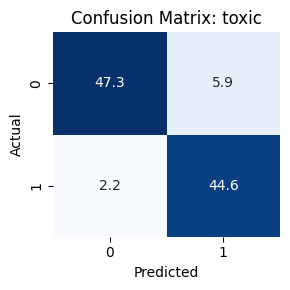


Confusion Matrix for 'severe_toxic':
[[92.06  3.  ]
 [ 1.71  3.22]]


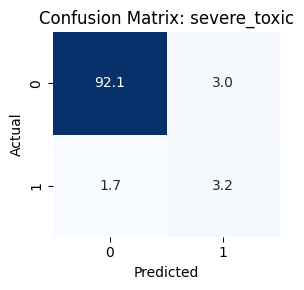


Confusion Matrix for 'obscene':
[[69.74  4.79]
 [ 2.42 23.05]]


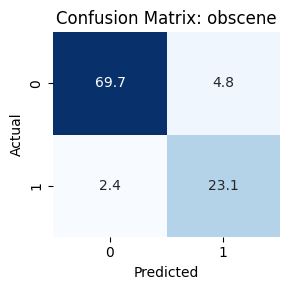


Confusion Matrix for 'insult':
[[68.52  7.46]
 [ 3.41 20.62]]


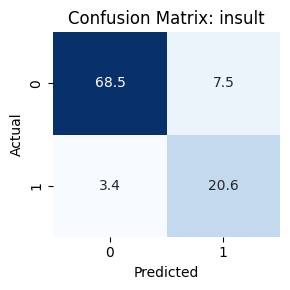


Confusion Matrix for 'identity_hate':
[[94.36  1.6 ]
 [ 1.25  2.79]]


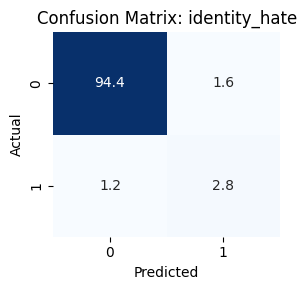

In [ ]:
evaluate_multilabel_model(
    trainer=trainer_25_base,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=True
)

## 50% Dataset

In [19]:
# Create the dataset
df_50pct, _ = get_stratified_subset(train, percentage=0.5)
print("50% subset size:", len(df_50pct))

# Verify approximate label frequencies in df_1pct
freqs_50pct = df_50pct[labels].sum() / len(df_50pct) * 100
print("\nLabel frequencies in the 50% subset (in %):")
print(freqs_50pct.round(2))

# Apply map() on out train dataset:
train_50 = Dataset.from_pandas(df_50pct).remove_columns("id")
train_50 = train_50.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_50.set_format("torch", ["input_ids","attention_mask","labels"])

# Load the Model
model50  = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

# Load the Trainer object
trainer_50 = WeightedLossTrainer(
    pos_weight=pos_weight_tensor,
    model=model50,
    args=args_1_base,
    train_dataset=train_50,
    eval_dataset=val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

50% subset size: 12980

Label frequencies in the 50% subset (in %):
toxic            47.12
severe_toxic      5.00
obscene          26.21
insult           24.45
identity_hate     4.33
dtype: float64


Map:   0%|          | 0/12980 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# TRAIN THE MODEL!
train_output_50 = trainer_50.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.560700,0.377640,0.880062,0.815753,0.907506,0.844501
2,0.421600,0.361214,0.907704,0.847831,0.917329,0.874447
3,0.348200,0.399888,0.930847,0.881686,0.929460,0.902276
4,0.215000,0.361996,0.923575,0.868884,0.933127,0.894656
5,0.168000,0.497508,0.941140,0.899168,0.934904,0.915314
6,0.109600,0.503729,0.940801,0.897998,0.936139,0.915096
7,0.084700,0.660457,0.946564,0.910470,0.935008,0.921962
8,0.089300,0.712698,0.948012,0.913189,0.935925,0.923896
9,0.069800,0.739362,0.949584,0.916238,0.936813,0.925990
10,0.063000,0.722097,0.949861,0.917101,0.936398,0.926280


In [ ]:
eval_results_50 = trainer_50.evaluate(eval_dataset=val)

print("\nEvaluation Results (50% dataset):")
print(f"  Accuracy:  {eval_results_50['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_50['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_50['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_50['eval_f1']:.4f}")


Evaluation Results (50% dataset):
  Accuracy:  0.9499
  Precision: 0.9171
  Recall:    0.9364
  F1 Score:  0.9263



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.9137    0.9634    0.9379      3034
 severe_toxic     0.6188    0.7000    0.6569       320
      obscene     0.8702    0.9286    0.8984      1653
       insult     0.8115    0.8724    0.8408      1559
identity_hate     0.7201    0.7366    0.7283       262

    micro avg     0.8578    0.9132    0.8846      6828
    macro avg     0.7869    0.8402    0.8125      6828
 weighted avg     0.8586    0.9132    0.8850      6828
  samples avg     0.4287    0.4500    0.4297      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[49.    4.25]
 [ 1.71 45.04]]


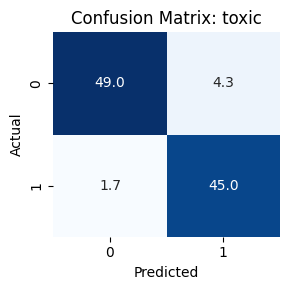


Confusion Matrix for 'severe_toxic':
[[92.94  2.13]
 [ 1.48  3.45]]


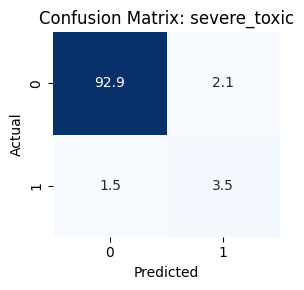


Confusion Matrix for 'obscene':
[[71.    3.53]
 [ 1.82 23.65]]


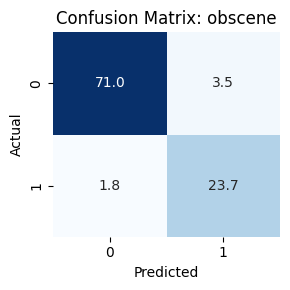


Confusion Matrix for 'insult':
[[71.11  4.87]
 [ 3.07 20.96]]


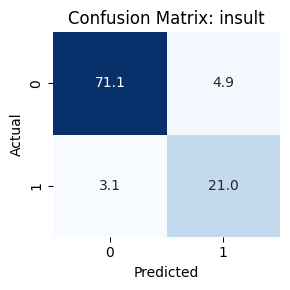


Confusion Matrix for 'identity_hate':
[[94.81  1.16]
 [ 1.06  2.97]]


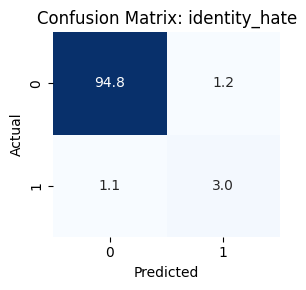

In [ ]:
evaluate_multilabel_model(
    trainer=trainer_50,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=True
)

## 75% Dataset

In [ ]:
# Create the dataset
df_75pct, _ = get_stratified_subset(train, percentage=0.75)
print("75% subset size:", len(df_75pct))

# Verify approximate label frequencies in df_1pct
freqs_75pct = df_75pct[labels].sum() / len(df_75pct) * 100
print("\nLabel frequencies in the 75% subset (in %):")
print(freqs_75pct.round(2))

# Apply map() on out train dataset:
train_75 = Dataset.from_pandas(df_75pct).remove_columns("id")
train_75 = train_75.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_75.set_format("torch", ["input_ids","attention_mask","labels"])

# Load the Model
model75  = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

# Load the Trainer object
trainer_75 = WeightedLossTrainer(
    pos_weight=pos_weight_tensor,
    model=model75,
    args=args_1_base,
    train_dataset=train_75,
    eval_dataset=val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

75% subset size: 19470

Label frequencies in the 75% subset (in %):
toxic            47.12
severe_toxic      5.00
obscene          26.21
insult           24.44
identity_hate     4.33
dtype: float64


Map:   0%|          | 0/19470 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# TRAIN THE MODEL!
train_output_75 = trainer_75.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.439900,0.352002,0.897227,0.834718,0.917677,0.863661
2,0.372400,0.319345,0.910847,0.852172,0.917601,0.877844
3,0.301300,0.302401,0.924314,0.869096,0.939020,0.896491
4,0.237900,0.379926,0.947458,0.909448,0.940999,0.923929
5,0.220600,0.343936,0.946379,0.903940,0.948803,0.923684
6,0.124800,0.359547,0.951464,0.913365,0.950572,0.930185
7,0.097300,0.453071,0.957720,0.926249,0.951902,0.938266
8,0.123300,0.491001,0.962126,0.935837,0.953135,0.944130
9,0.088900,0.500301,0.963082,0.937484,0.954169,0.945497
10,0.055500,0.505889,0.963945,0.938949,0.955146,0.946738


In [ ]:
eval_results_75 = trainer_75.evaluate(eval_dataset=val)

print("\nEvaluation Results (75% dataset):")
print(f"  Accuracy:  {eval_results_75['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_75['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_75['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_75['eval_f1']:.4f}")


Evaluation Results (75% dataset):
  Accuracy:  0.9639
  Precision: 0.9389
  Recall:    0.9551
  F1 Score:  0.9467



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.9331    0.9753    0.9537      3034
 severe_toxic     0.7036    0.7937    0.7460       320
      obscene     0.9105    0.9474    0.9286      1653
       insult     0.8669    0.9108    0.8883      1559
identity_hate     0.7604    0.8359    0.7964       262

    micro avg     0.8941    0.9400    0.9165      6828
    macro avg     0.8349    0.8926    0.8626      6828
 weighted avg     0.8951    0.9400    0.9169      6828
  samples avg     0.4474    0.4638    0.4487      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[49.98  3.27]
 [ 1.16 45.59]]


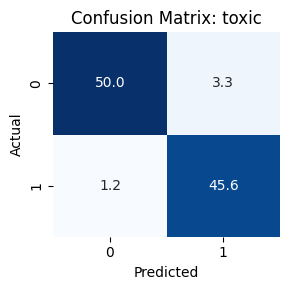


Confusion Matrix for 'severe_toxic':
[[93.42  1.65]
 [ 1.02  3.91]]


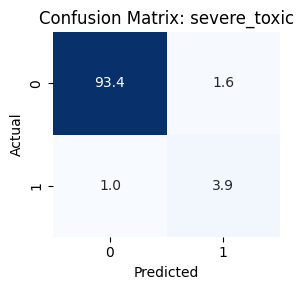


Confusion Matrix for 'obscene':
[[72.16  2.37]
 [ 1.34 24.13]]


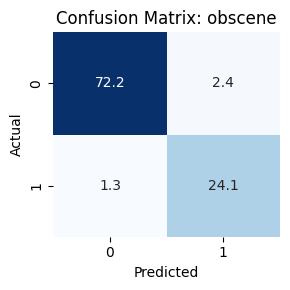


Confusion Matrix for 'insult':
[[72.62  3.36]
 [ 2.14 21.88]]


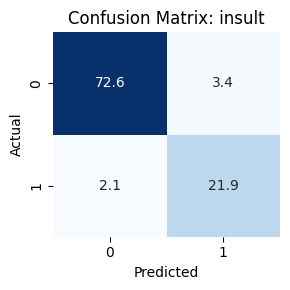


Confusion Matrix for 'identity_hate':
[[94.9   1.06]
 [ 0.66  3.37]]


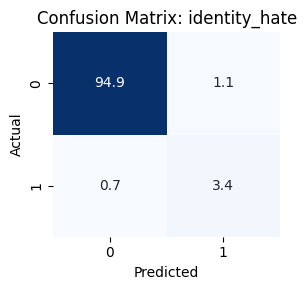

In [ ]:
evaluate_multilabel_model(
    trainer=trainer_75,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=True
)

## 100% Dataset

In [ ]:
# Apply map() on out train dataset:
train_100 = Dataset.from_pandas(train).remove_columns("id")
train_100 = train_100.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_100.set_format("torch", ["input_ids","attention_mask","labels"])

# Load the Model
model100  = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

# Load the Trainer object
trainer_100 = Trainer(
    model           = model100,
    args            = args_1_base,
    train_dataset   = train_100,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

Map:   0%|          | 0/25960 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# TRAIN THE MODEL!
train_output_100 = trainer_100.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.173500,0.148476,0.938243,0.916789,0.893429,0.904429
2,0.154500,0.126107,0.948475,0.924017,0.920265,0.922124
3,0.129500,0.108989,0.956302,0.930829,0.939080,0.934872
4,0.120600,0.099468,0.961911,0.931728,0.959014,0.944469
5,0.081100,0.079372,0.973128,0.954971,0.965312,0.960021
6,0.052900,0.074584,0.977565,0.964014,0.968874,0.966418
7,0.057200,0.072534,0.979753,0.968622,0.970582,0.969598
8,0.040600,0.071871,0.981387,0.972135,0.971831,0.971983
9,0.029900,0.073705,0.982342,0.971288,0.975873,0.973558
10,0.021300,0.073512,0.982897,0.973143,0.975526,0.974329


In [ ]:
eval_results_100 = trainer_100.evaluate(eval_dataset=val)

print("\nEvaluation Results (100% dataset):")
print(f"  Accuracy:  {eval_results_100['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_100['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_100['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_100['eval_f1']:.4f}")


Evaluation Results (100% dataset):
  Accuracy:  0.9829
  Precision: 0.9731
  Recall:    0.9755
  F1 Score:  0.9743



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.9778    0.9858    0.9818      3034
 severe_toxic     0.8209    0.8594    0.8397       320
      obscene     0.9622    0.9698    0.9660      1653
       insult     0.9446    0.9410    0.9428      1559
identity_hate     0.9084    0.9084    0.9084       262

    micro avg     0.9562    0.9628    0.9595      6828
    macro avg     0.9228    0.9329    0.9277      6828
 weighted avg     0.9564    0.9628    0.9596      6828
  samples avg     0.4753    0.4771    0.4732      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[52.2   1.05]
 [ 0.66 46.09]]


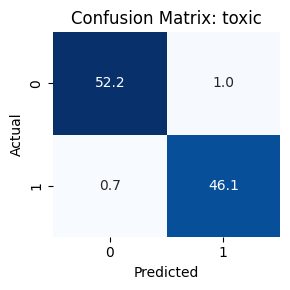


Confusion Matrix for 'severe_toxic':
[[94.14  0.92]
 [ 0.69  4.24]]


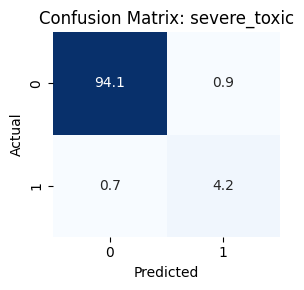


Confusion Matrix for 'obscene':
[[73.56  0.97]
 [ 0.77 24.7 ]]


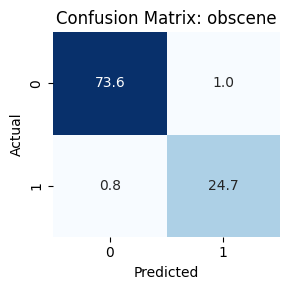


Confusion Matrix for 'insult':
[[74.65  1.33]
 [ 1.42 22.6 ]]


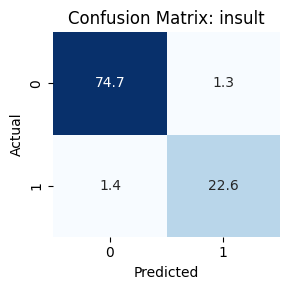


Confusion Matrix for 'identity_hate':
[[95.59  0.37]
 [ 0.37  3.67]]


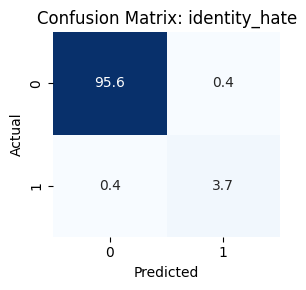

In [ ]:
evaluate_multilabel_model(
    trainer=trainer_100,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=True
)

## Additional Experiments

### Focal Loss
We now try out a different loss function. Focal Loss explicitly down-weights easy negatives and focuses on hard / rare positives, so we may get better performance for the rare classes. We test it out on the 50% dataset, to compare with our base 50% (that uses the BCEWithLogits).

In [ ]:
class FocalLoss(nn.Module):
    """
    Multi-label focal loss for binary classification per label
    """
    def __init__(
        self,
        alpha: Union[float, torch.Tensor] = 1.0,
        gamma: float = 2.0,
        reduction: str = "mean",
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # logits: (batch_size, num_labels), labels: same shape
        bce = nn.functional.binary_cross_entropy_with_logits(logits, labels.float(), reduction="none")
        p = torch.sigmoid(logits)
        p_t = p * labels + (1 - p) * (1 - labels)            # p_t = p if label=1 else 1-p
        mod_factor = (1 - p_t) ** self.gamma
        alpha_factor = self.alpha if isinstance(self.alpha, float) else self.alpha.unsqueeze(0)
        loss = alpha_factor * mod_factor * bce
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss  # no reduction

class FocalTrainer(Trainer):
    def __init__(self, focal_loss: FocalLoss, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss = focal_loss

    def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.focal_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
#  instantiate  focal loss
focal_loss_fn = FocalLoss(alpha=1.0, gamma=2.0, reduction="mean")

# load a fresh model as usual
model_focal = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,
    problem_type="multi_label_classification"
)

trainer_focal = FocalTrainer(
    focal_loss = focal_loss_fn,
    model      = model_focal,
    args       =args_1_base ,
    train_dataset = train_50,
    eval_dataset  = val,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

Map:   0%|          | 0/12980 [00:00<?, ? examples/s]

In [ ]:
trainer_focal.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.050500,0.043879,0.930508,0.889821,0.906095,0.897594
2,0.040900,0.039889,0.938737,0.907578,0.908190,0.907883
3,0.033600,0.036126,0.945362,0.919687,0.915018,0.917325
4,0.026200,0.038068,0.945393,0.910487,0.930023,0.919763
5,0.017800,0.041115,0.950909,0.925140,0.927554,0.926340
6,0.014100,0.045593,0.951741,0.925160,0.930606,0.927846
7,0.008800,0.050831,0.952974,0.926810,0.932729,0.929727
8,0.008400,0.056689,0.953806,0.933233,0.926810,0.929972
9,0.006800,0.058612,0.953898,0.931019,0.930092,0.930554
10,0.005400,0.059450,0.953806,0.929173,0.932343,0.930746


TrainOutput(global_step=8120, training_loss=0.02229438580462498, metrics={'train_runtime': 635.3643, 'train_samples_per_second': 204.292, 'train_steps_per_second': 12.78, 'total_flos': 4298797062912000.0, 'train_loss': 0.02229438580462498, 'epoch': 10.0})

In [ ]:
eval_results_focal = trainer_focal.evaluate(eval_dataset=val)

print("\nEvaluation Results (100% dataset):")
print(f"  Accuracy:  {eval_results_focal['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_focal['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_focal['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_focal['eval_f1']:.4f}")


Evaluation Results (100% dataset):
  Accuracy:  0.9538
  Precision: 0.9292
  Recall:    0.9323
  F1 Score:  0.9307



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.9323    0.9578    0.9449      3034
 severe_toxic     0.6667    0.6562    0.6614       320
      obscene     0.8896    0.9117    0.9005      1653
       insult     0.8458    0.8339    0.8398      1559
identity_hate     0.8120    0.7252    0.7661       262

    micro avg     0.8863    0.8953    0.8908      6828
    macro avg     0.8293    0.8170    0.8225      6828
 weighted avg     0.8852    0.8953    0.8900      6828
  samples avg     0.4384    0.4424    0.4319      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[50.    3.25]
 [ 1.97 44.78]]


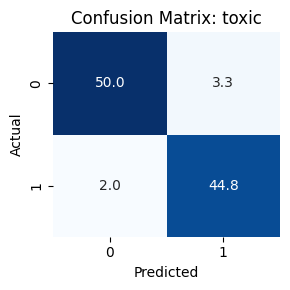


Confusion Matrix for 'severe_toxic':
[[93.45  1.62]
 [ 1.69  3.24]]


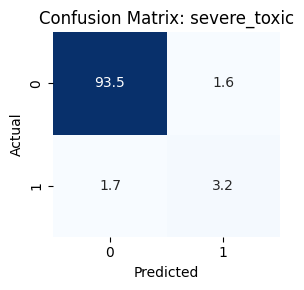


Confusion Matrix for 'obscene':
[[71.65  2.88]
 [ 2.25 23.22]]


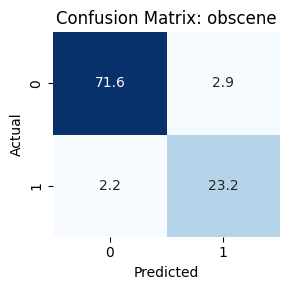


Confusion Matrix for 'insult':
[[72.33  3.65]
 [ 3.99 20.03]]


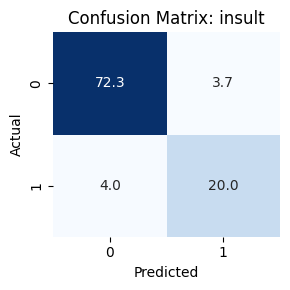


Confusion Matrix for 'identity_hate':
[[95.29  0.68]
 [ 1.11  2.93]]


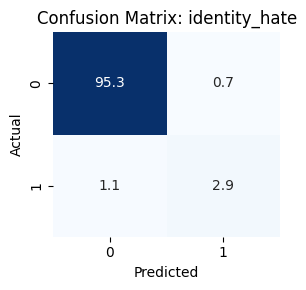

In [ ]:
evaluate_multilabel_model(
    trainer=trainer_focal,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=True
)

### Learning Rate Tuning
We can also experiment with the Learning Rate value. To do so, we make some trials using the 50% dataset. We use Hugging Face’s built-in hyperparameter search with Optuna, which explores a log-uniform range and maximizes the validation F1.


In [25]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        "distilbert/distilbert-base-uncased",
        num_labels=5,
        problem_type="multi_label_classification"
    )

# Define special arguments
training_args = TrainingArguments(
    output_dir="./hp_search",
    eval_strategy="epoch",
    save_strategy="no",
    load_best_model_at_end=False,  # we only care about the hyper-search
    num_train_epochs=3,            # keep each trial short
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    metric_for_best_model="eval_f1",
    fp16=True,
)

os.environ["WANDB_DISABLED" ] = "true"
trainer = Trainer(
    model_init=model_init,                     # your fresh model
    args=training_args,
    train_dataset=train_50,
    eval_dataset=val,
    compute_metrics=compute_metrics,
)

# Define an Optuna search space
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
        # you can also tune warmup_steps, weight_decay, etc.
    }

#  Launch the search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=10,
    hp_space=optuna_hp_space
)

print("Best trial:", best_run)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-07 15:55:28,736] A new study created in memory with name: no-name-7bf57e86-867e-461a-9481-a2da4b6e2109
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.284900,0.190178,0.923390,0.880048,0.894229,0.886852
2,0.181000,0.167777,0.931741,0.898040,0.896026,0.897028
3,0.165600,0.161825,0.935039,0.903212,0.900692,0.901944


[I 2025-06-07 15:59:33,886] Trial 0 finished with value: 3.6408858992746653 and parameters: {'learning_rate': 9.580975428145602e-06}. Best is trial 0 with value: 3.6408858992746653.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.454500,0.268090,0.912542,0.884354,0.842509,0.861018
2,0.254400,0.232627,0.916857,0.882767,0.861140,0.871303
3,0.239100,0.225400,0.917689,0.883447,0.863386,0.872858


[I 2025-06-07 16:02:47,507] Trial 1 finished with value: 3.5373786459455756 and parameters: {'learning_rate': 1.7242074229245265e-06}. Best is trial 0 with value: 3.6408858992746653.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.287900,0.191811,0.922743,0.879002,0.893496,0.885950
2,0.182500,0.168753,0.931649,0.898472,0.894946,0.896693
3,0.167200,0.162936,0.934792,0.903176,0.899784,0.901465


[I 2025-06-07 16:06:10,791] Trial 2 finished with value: 3.6392167429066458 and parameters: {'learning_rate': 9.129305431133393e-06}. Best is trial 0 with value: 3.6408858992746653.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.228600,0.164189,0.933159,0.897810,0.902187,0.899973
2,0.151500,0.151670,0.939137,0.902650,0.918381,0.910189
3,0.120900,0.141687,0.945701,0.915611,0.922430,0.918962


[I 2025-06-07 16:09:30,125] Trial 3 finished with value: 3.7027030581640186 and parameters: {'learning_rate': 4.7688937449805874e-05}. Best is trial 3 with value: 3.7027030581640186.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485500,0.293764,0.909245,0.883466,0.831665,0.853858
2,0.273800,0.249491,0.914052,0.880482,0.853563,0.866008
3,0.256000,0.240717,0.915624,0.882245,0.857083,0.868783


[I 2025-06-07 16:12:42,942] Trial 4 finished with value: 3.5237352226255036 and parameters: {'learning_rate': 1.347259940220113e-06}. Best is trial 3 with value: 3.7027030581640186.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.269100,0.182632,0.924715,0.882104,0.895927,0.888746
2,0.172800,0.162518,0.933929,0.899188,0.902944,0.901047
3,0.156700,0.155872,0.937565,0.905322,0.907234,0.906273


[I 2025-06-07 16:15:58,537] Trial 5 finished with value: 3.6563946979699464 and parameters: {'learning_rate': 1.2621911282108437e-05}. Best is trial 3 with value: 3.7027030581640186.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.397400,0.233309,0.916733,0.883027,0.860256,0.870922


[I 2025-06-07 16:17:00,151] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.230200,0.165667,0.931063,0.892345,0.903438,0.897724
2,0.152300,0.150520,0.939908,0.904560,0.918063,0.911073
3,0.124000,0.141627,0.944561,0.913840,0.920848,0.917282


[I 2025-06-07 16:20:06,860] Trial 7 finished with value: 3.696530550534386 and parameters: {'learning_rate': 4.044890545253937e-05}. Best is trial 3 with value: 3.7027030581640186.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.234300,0.167736,0.930293,0.890880,0.902951,0.896716
2,0.154800,0.151285,0.940062,0.905573,0.916871,0.911056
3,0.130000,0.142806,0.943143,0.912005,0.918286,0.915095


[I 2025-06-07 16:23:24,110] Trial 8 finished with value: 3.6885284254568123 and parameters: {'learning_rate': 3.252657075473205e-05}. Best is trial 3 with value: 3.7027030581640186.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.229800,0.165805,0.930878,0.891856,0.903590,0.897535
2,0.152100,0.150423,0.939692,0.904261,0.917711,0.910749
3,0.123500,0.141834,0.944746,0.914113,0.921127,0.917558


[I 2025-06-07 16:26:41,411] Trial 9 finished with value: 3.697543151813544 and parameters: {'learning_rate': 4.154561830224282e-05}. Best is trial 3 with value: 3.7027030581640186.


Best trial: BestRun(run_id='3', objective=3.7027030581640186, hyperparameters={'learning_rate': 4.7688937449805874e-05}, run_summary=None)


Given that the learning rate search defines the optimal value at 4.7688937449805874e-05, we now deploy it in our 100% Dataset.

In [27]:
train_100 = Dataset.from_pandas(train).remove_columns("id")
train_100 = train_100.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_100.set_format("torch", ["input_ids","attention_mask","labels"])


# Load the Model
model100  = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=5,                     # one output node per toxicity sublabel
    problem_type="multi_label_classification"  # so it uses a sigmoid + BCE‐with‐logits
)

# For the full dataset, we experiment using more epochs.
args_100_bis = TrainingArguments(
    output_dir          = "./bert_1",
    eval_strategy       = "epoch",
    save_strategy       = "no",
    logging_strategy    = "steps",
    logging_steps       = 50,
    learning_rate       = 4.7688937449805874e-05,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 15,
    weight_decay        = 0.01,
    load_best_model_at_end = False,
    metric_for_best_model = "eval_f1",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True # Enable mixed precision training
)

# Load the Trainer object
trainer_100 = Trainer(
    model           = model100,
    args            = args_1_base,
    train_dataset   = train_100,
    eval_dataset    = val,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

Map:   0%|          | 0/25960 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
train_output_100 = trainer_100.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.172900,0.147884,0.938398,0.915821,0.895192,0.904974
2,0.153900,0.125599,0.948844,0.926234,0.918566,0.922328
3,0.126800,0.109907,0.956610,0.929191,0.942713,0.935730
4,0.116700,0.099348,0.962496,0.932635,0.959761,0.945309
5,0.078300,0.082276,0.972234,0.952435,0.965605,0.958823
6,0.049100,0.078056,0.975994,0.960052,0.968523,0.964208
7,0.053800,0.074040,0.979045,0.966127,0.971207,0.968639
8,0.038200,0.074766,0.981140,0.971147,0.972158,0.971651
9,0.025700,0.075513,0.981787,0.970738,0.974716,0.972710
10,0.023800,0.076428,0.982126,0.971686,0.974716,0.973191


In [29]:
eval_results_100 = trainer_100.evaluate(eval_dataset=val)

print("\nEvaluation Results (100% dataset):")
print(f"  Accuracy:  {eval_results_100['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_100['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_100['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_100['eval_f1']:.4f}")



Evaluation Results (100% dataset):
  Accuracy:  0.9821
  Precision: 0.9717
  Recall:    0.9747
  F1 Score:  0.9732



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.9774    0.9842    0.9808      3034
 severe_toxic     0.8107    0.8562    0.8328       320
      obscene     0.9589    0.9734    0.9661      1653
       insult     0.9390    0.9384    0.9387      1559
identity_hate     0.9112    0.9008    0.9060       262

    micro avg     0.9535    0.9619    0.9577      6828
    macro avg     0.9194    0.9306    0.9249      6828
 weighted avg     0.9538    0.9619    0.9578      6828
  samples avg     0.4732    0.4758    0.4714      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[52.19  1.06]
 [ 0.74 46.01]]


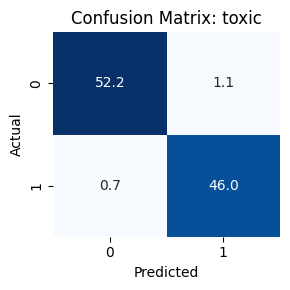


Confusion Matrix for 'severe_toxic':
[[94.08  0.99]
 [ 0.71  4.22]]


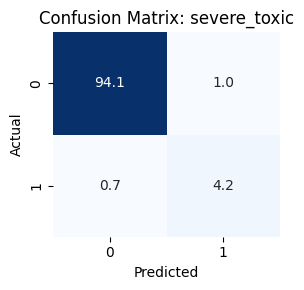


Confusion Matrix for 'obscene':
[[73.47  1.06]
 [ 0.68 24.79]]


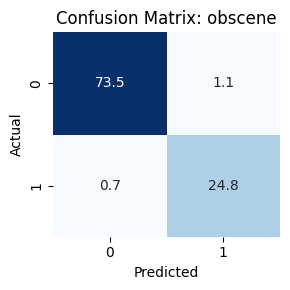


Confusion Matrix for 'insult':
[[74.51  1.46]
 [ 1.48 22.54]]


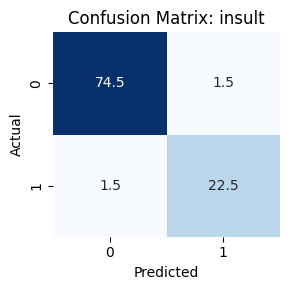


Confusion Matrix for 'identity_hate':
[[95.61  0.35]
 [ 0.4   3.64]]


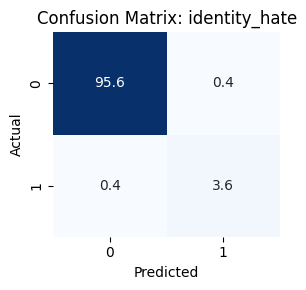

In [30]:
evaluate_multilabel_model(
    trainer=trainer_100,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=True
)

### Comparison

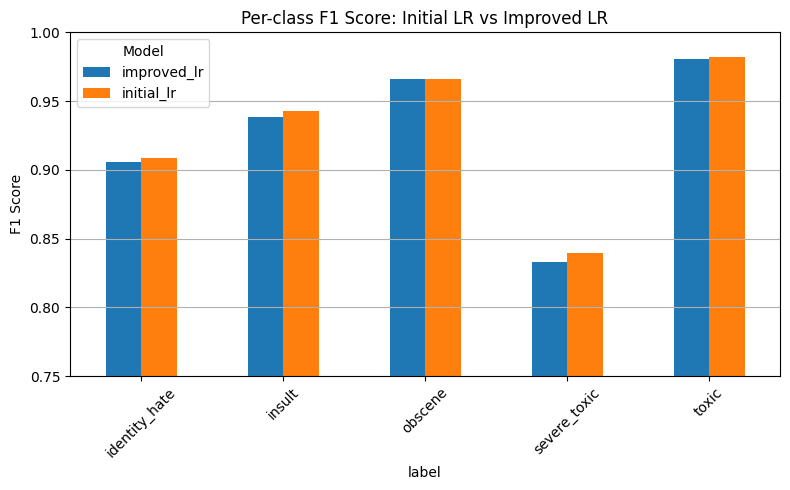

In [33]:
results = [
    {"model": "initial_lr", "label": "toxic",         "f1": 0.9818},
    {"model": "initial_lr", "label": "severe_toxic",  "f1": 0.8397},
    {"model": "initial_lr", "label": "obscene",       "f1": 0.9660},
    {"model": "initial_lr", "label": "insult",        "f1": 0.9428},
    {"model": "initial_lr", "label": "identity_hate", "f1": 0.9084},

    {"model": "improved_lr", "label": "toxic",         "f1": 0.9808},
    {"model": "improved_lr", "label": "severe_toxic",  "f1": 0.8328},
    {"model": "improved_lr", "label": "obscene",       "f1": 0.9661},
    {"model": "improved_lr", "label": "insult",        "f1": 0.9387},
    {"model": "improved_lr", "label": "identity_hate", "f1": 0.9060},
]

df = pd.DataFrame(results)
df_pivot = df.pivot(index="label", columns="model", values="f1")
# Plot grouped bar chart
df_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("Per-class F1 Score: Initial LR vs Improved LR")
plt.ylabel("F1 Score")
plt.ylim(0.75, 1.0)
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

When comparing this model with the inital learning rate, we find very similar results. The overall F1 score is subtly higher in the initial model, and when looking at the per class metrics we can observe a slighlty better performance in the initial learning rate.

In [32]:
save_path = "./final_model"

# Save model weights + config
model100.save_pretrained(save_path)

In [31]:
# later we can re load it using
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# model     = AutoModelForSequenceClassification.from_pretrained("/path/to/checkpoint")

# Learning Curves

In [37]:
overall_results = [
    {"pct":  1,  "acc": 0.9052, "prec": 0.8636, "rec": 0.8447, "f1": 0.8536},
    {"pct": 10,  "acc": 0.9275, "prec": 0.8922, "rec": 0.8888, "f1": 0.8905},
    {"pct": 25,  "acc": 0.9325, "prec": 0.8883, "rec": 0.9190, "f1": 0.9023},
    {"pct": 50,  "acc": 0.9499, "prec": 0.9171, "rec": 0.9364, "f1": 0.9263},
    {"pct": 75,  "acc": 0.9639, "prec": 0.9389, "rec": 0.9551, "f1": 0.9467},
    {"pct":100,  "acc": 0.9829, "prec": 0.9731, "rec": 0.9755, "f1": 0.9743},
]

df_metrics = pd.DataFrame(overall_results).sort_values("pct")


perlabel_results = [
    # 1%
    {"pct":1, "label":"toxic", "f1":0.8770},
    {"pct":1, "label":"severe_toxic", "f1":0.0000},
    {"pct":1, "label":"obscene", "f1":0.7761},
    {"pct":1, "label":"insult", "f1":0.6881},
    {"pct":1, "label":"identity_hate", "f1":0.0000},

    # 10%
    {"pct":10, "label":"toxic", "f1":0.9015},
    {"pct":10, "label":"severe_toxic", "f1":0.5328},
    {"pct":10, "label":"obscene", "f1":0.8402},
    {"pct":10, "label":"insult", "f1":0.7556},
    {"pct":10, "label":"identity_hate", "f1":0.5832},

    # 25%
    {"pct":25, "label":"toxic", "f1":0.9165},
    {"pct":25, "label":"severe_toxic", "f1":0.5773},
    {"pct":25, "label":"obscene", "f1":0.8647},
    {"pct":25, "label":"insult", "f1":0.7915},
    {"pct":25, "label":"identity_hate", "f1":0.6618},

    # 50%
    {"pct":50, "label":"toxic", "f1":0.9379},
    {"pct":50, "label":"severe_toxic", "f1":0.6569},
    {"pct":50, "label":"obscene", "f1":0.8984},
    {"pct":50, "label":"insult", "f1":0.8408},
    {"pct":50, "label":"identity_hate", "f1":0.7283},

    # 75%
    {"pct":75, "label":"toxic", "f1":0.9537},
    {"pct":75, "label":"severe_toxic", "f1":0.7460},
    {"pct":75, "label":"obscene", "f1":0.9286},
    {"pct":75, "label":"insult", "f1":0.8883},
    {"pct":75, "label":"identity_hate", "f1":0.7964},

    # 100%
    {"pct":100, "label":"toxic", "f1":0.9818},
    {"pct":100, "label":"severe_toxic", "f1":0.8397},
    {"pct":100, "label":"obscene", "f1":0.9660},
    {"pct":100, "label":"insult", "f1":0.9428},
    {"pct":100, "label":"identity_hate", "f1":0.9084},
]

df = pd.DataFrame(perlabel_results)

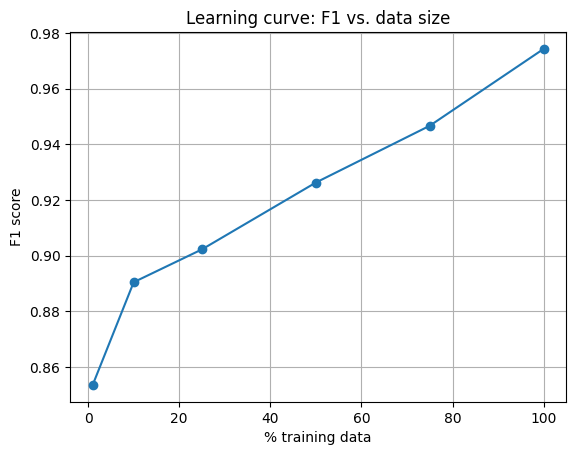

In [35]:
plt.plot(df_metrics["pct"], df_metrics["f1"], marker="o")
plt.xlabel("% training data")
plt.ylabel("F1 score")
plt.title("Learning curve: F1 vs. data size")
plt.grid(True)
plt.show()

### F1 score evolution of the rare classes

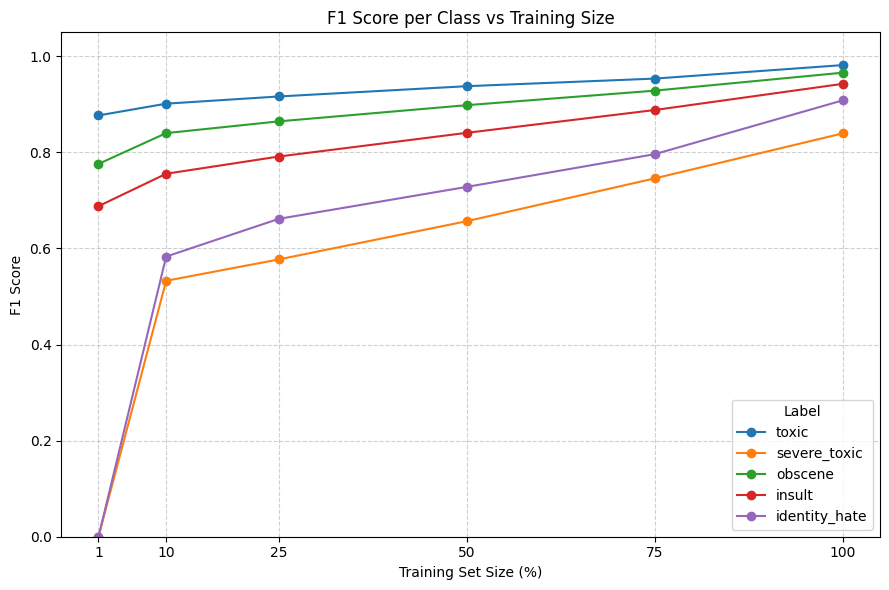

In [38]:
plt.figure(figsize=(9, 6))

# Plot one curve per label
for label in df["label"].unique():
    df_label = df[df["label"] == label]
    plt.plot(df_label["pct"], df_label["f1"], marker='o', label=label)

plt.title("F1 Score per Class vs Training Size")
plt.xlabel("Training Set Size (%)")
plt.ylabel("F1 Score")
plt.xticks([1, 10, 25, 50, 75, 100])
plt.ylim(0.0, 1.05)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Label")
plt.tight_layout()
plt.show()